<a href="https://colab.research.google.com/github/es2mac/DrillTraining/blob/main/DrillAI_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DrillAI Training

## Preparation

### Imports

In [1]:
# ...if exporting CoreML model
# !pip install coremltools
# !pip install coremltools==5.0b4

# import coremltools as ct

In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from statistics import median
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import json
# from google.protobuf import text_format # use as: text_format.MessageToString(...)

In [3]:
# Download the GameRecord protobuf definition from GitHub
!wget -nc https://raw.githubusercontent.com/es2mac/DrillAI/main/Sources/DrillAI/MLModel/GameRecord/DrillGameRecord_pb2.py

from DrillGameRecord_pb2 import GameRecord

--2021-09-10 14:20:29--  https://raw.githubusercontent.com/es2mac/DrillAI/main/Sources/DrillAI/MLModel/GameRecord/DrillGameRecord_pb2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6647 (6.5K) [text/plain]
Saving to: ‘DrillGameRecord_pb2.py’

DrillGameRecord_pb2 100%[===================>]   6.49K  --.-KB/s    in 0s      

2021-09-10 14:20:29 (31.0 MB/s) - ‘DrillGameRecord_pb2.py’ saved [6647/6647]



### Load raw data

In [4]:
# Link to Google Drive for records (manual upload)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
workingDirectory = "/content/drive/MyDrive/DrillAI/"
zipFileName = "records_gen1.zip"
recordsDirectoryName = "records"

!ls {workingDirectory}

0909_model_badly_saved_as_functions  drillModel_010.pth  records_gen1.zip
0909_model_value_loss_blew_up	     drillModel_040.pth  trainingSummaries.json


In [ ]:
# Unzip records to local directory

!unzip -n {workingDirectory + zipFileName} -d .

In [7]:
# Read and aggregate steps from all the games
allSteps = []

recordsDirectory = os.fsdecode(recordsDirectoryName)
gameRecord = GameRecord()
for file in os.listdir(recordsDirectory):
    data = open(f"{recordsDirectory}/{file}", "rb").read()
    gameRecord.ParseFromString(data)
    allSteps += gameRecord.steps

Total steps: 46711
Median value: 0.4285714328289032


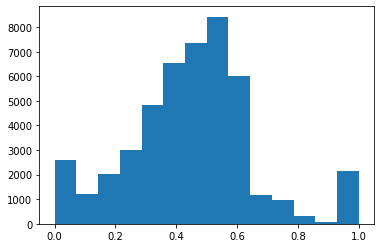

In [8]:
# Inspect data
def inspectData(allSteps):
    print("Total steps:", len(allSteps))
    allValues = [step.value for step in allSteps]
    plt.hist(allValues, bins=14)

    print("Median value:", median(allValues)) # 0.2857 = 4/14, 0.4286 = 6/14

inspectData(allSteps)

## Define Models

In [9]:
# Define a slice of convolution + batch norm
class ConvBN(nn.Module):
    """
    Convolution + batch norm.
    Note that CoreML conversion can't actually take same padding atm.
    Workaround:  Pass in an actual int.
    """
    def __init__(self, inChannels, outChannels, kernelSize, padding="same"):
        super(ConvBN, self).__init__()
        self.conv = nn.Conv2d(in_channels=inChannels,
                              out_channels=outChannels,
                              kernel_size=kernelSize,
                              padding=padding)
        self.norm = nn.BatchNorm2d(num_features=outChannels)

    def forward(self, x):
        return self.norm(self.conv(x))


# Define a residual block that is just two ConvBNs
class ResidualBlock(nn.Module):
    def __init__(self, featureCount, kernelSize):
        super(ResidualBlock, self).__init__()
        padding = (kernelSize - 1) // 2
        self.layer1 = ConvBN(featureCount, featureCount, kernelSize, padding)
        self.layer2 = ConvBN(featureCount, featureCount, kernelSize, padding)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [10]:
class DrillModel(nn.Module):
    def __init__(self, blockCount):
        super(DrillModel, self).__init__()
        kernelSize = 3
        padding = 1
        featureCount = 43
        convWidth = 32
        valueDenseWidth = 32

        self.initialConv = ConvBN(featureCount, convWidth, kernelSize, padding)
        self.residualBlocks = nn.ModuleList([
            ResidualBlock(convWidth, kernelSize)
            for _ in range(blockCount)
        ])

        self.policyConv1 = ConvBN(convWidth, convWidth, kernelSize, padding)
        self.policyConv2 = ConvBN(convWidth, 8, kernelSize, padding)

        self.valueConv = ConvBN(convWidth, 1, 1, 0)
        self.flatten = nn.Flatten()
        self.valueLinear1 = nn.Linear(10 * 20, valueDenseWidth)
        self.valueLinear2 = nn.Linear(valueDenseWidth, 1)

    def forward(self, x):
        common = F.relu(self.initialConv(x))
        for block in self.residualBlocks:
            common = block(common)
        
        # policy head
        logits = F.relu(self.policyConv1(common))
        logits = self.policyConv2(logits)

        # value head
        value = F.relu(self.valueConv(common))
        value = self.flatten(value)
        value = self.valueLinear1(value)
        value = torch.sigmoid(self.valueLinear2(value))

        return (value, logits)

## Data Parsing and Augmentation

To go between model trained on CPU/GPU to the other:
[Saving and loading models across devices in pytorch](https://pytorch.org/tutorials/recipes/recipes/save_load_across_devices.html)

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [12]:
# I, J, L, O, S, T, Z
# 0, 1, 2, 3, 4, 5, 6
flippedTetromino = [0, 2, 1, 3, 6, 5, 4]
# up, right, down, left
flippedOrientation = [0, 3, 2, 1]

class DataEntry:
    """
    A specification of what a data entry is, that can be unpacked into
    appropriate sample & label.
    """
    def __init__(self, step, addLines=0, removeLines=0, flip=False):
        self.step = step
        self.addLines = addLines
        self.removeLines = removeLines
        self.flip = flip
        # self.previewCount = previewCount

    def __repr__(self):
        return f"{len(self.step.fieldCells)//10} lines, value {self.step.value:.3f}, +{self.addLines} -{self.removeLines} {'flipped' if self.flip else ''}"

    def parsedSample(self) -> np.ndarray:
        """
        Construct the sample input from a step.  Returns an ndarray of shape
        43 x 20 x 10
        The 43 layers are: the field, and 6 play pieces each with 7 cases.
        """
        field = np.array(self.step.fieldCells).astype('float32')
        tetrominos = self.step.tetrominos[:6]

        # Add solid lines, though not legal game-wise
        if self.addLines:
            field = np.pad(field, (self.addLines * 10, 0), constant_values=1)

        # Remove lines
        if self.removeLines:
            field = np.array(field[self.removeLines * 10:])

        ## Flip
        if self.flip:
            field.shape = (len(field) // 10, 10)
            field = np.flip(field, axis=1).flatten()
            tetrominos = [flippedTetromino[t] for t in tetrominos]

        # Assemble
        field.resize(1 + 6 * 7, 20, 10, refcheck=False)
        for (index, value) in enumerate(tetrominos):
            field[1 + index * 7 + value] = 1
        return field

    def parsedLabel(self) -> (float, int):
        """
        Construct the output labels from a step, i.e. value and best action.
        Note that the best action is to be compared (cross entropy) with a
        prior, which is of shape (4 + 4) x 20 x 10, where the first dimension
        represents the 4 rotations of each of the two pieces in play.  The best
        action would be its linear index in the prior.
        """
        value = np.float32(self.step.value)
        bestAction = self.step.actions[0]

        bestAction += 10 * self.addLines
        bestAction -= 10 * self.removeLines

        if self.flip:   # oops... need to unpack and put back together
            pieceOrder = bestAction // 800
            orientation = (bestAction % 800) // 200
            y = (bestAction % 200) // 10
            x = bestAction % 10

            orientation = flippedOrientation[orientation]
            x = 9 - x
            bestAction = 800 * pieceOrder + 200 * orientation + y * 10 + x

        return value, bestAction

In [13]:
def augmentedEntryVariants(step) -> [DataEntry]:
    """
    Decide and construct variant information for a step.  Possible variant
    augmentations are: reducing 1 or 2 bottom lines, adding 1 or 2 solid lines,
    and horizontal flip.  Each subject to certain conditions.
    """
    heightVariants = [(0, 0)]   # (add, remove)
    lineCount = len(step.fieldCells) // 10

    # print(lineCount)
    # print(step.fieldCells[70:80].count(True) == 9)
    # print(step.value)

    if lineCount >= 8:
        # at least 7 garbages, not all cleared: remove 1 line
        if (step.fieldCells[60:70].count(True) == 9 and
            step.value < 7/14):
            heightVariants.append((0, 1))
        # 8 garbages, not all cleared
        if (step.fieldCells[70:80].count(True) == 9 and
            step.value < 8/14):
            # remove 2 lines
            if step.value < 7/14:
                heightVariants.append((0, 2))
            # add 1~2 lines (under some arbitrary "too high" height)
            if lineCount < 16:
                heightVariants.append((1, 0))
                heightVariants.append((2, 0))

    flipVariants = [False] if 0 in step.tetrominos[:2] else [False, True]

    variants = []
    for flip in flipVariants:
        for addLines, removeLines in heightVariants:
            entry = DataEntry(step, addLines=addLines, removeLines=removeLines,
                              flip=flip)
            variants.append(entry)

    # print(heightVariants)
    # print(flipVariants)
    return variants

# augmentedEntryVariants(allSteps[6674])

In [14]:
# Dataset to wrap the data

class DrillDataset(Dataset):
    def __init__(self, steps):
        entries = []
        for step in steps:
            entries.extend(augmentedEntryVariants(step))
        self.entries = entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, index):
        entry = self.entries[index]
        sample = torch.from_numpy(entry.parsedSample()).to(device)
        value, bestAction = entry.parsedLabel()
        value = torch.tensor(value, dtype=torch.float32).to(device)
        bestAction = torch.tensor(bestAction, dtype=torch.long).to(device)
        return sample, (value, bestAction)


## Training

### Create/load model and datasets

In [15]:
# Initiate model, or load one
# TODO: save/load to drive
model = DrillModel(blockCount=4).to(device)

# torchModelFileName = "drillModel.pth"
torchModelFileName = "0909_model_badly_saved_as_functions/drillModel_040.pth"
# model.load_state_dict(torch.load(workingDirectory + torchModelFileName))
model.load_state_dict(torch.load(workingDirectory + torchModelFileName, map_location=torch.device('cpu'))())
# model.train()
model.eval()

def saveTorchModel():
    torch.save(model.state_dict(), workingDirectory + torchModelFileName)

In [74]:
# Test running a single sample through the model
def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

def inspectRandomPrediction():
    randomStep = random.choice(allSteps)
    entry = DataEntry(randomStep, addLines=0, removeLines=0, flip=False)
    sample = torch.from_numpy(entry.parsedSample()).unsqueeze(0).to(device)
    label = entry.parsedLabel()
    
    value, policies = model(sample)
    value = value.item()
    policies = policies.detach().numpy().flatten()[randomStep.actions]
    policies /= 2 # arbitrary: this visually gives better fit
    policies = softmax(policies)
    
    plt.bar(["value truth", "value prediction"], [randomStep.value, value])
    plt.show()
    
    plt.plot(randomStep.priors,label="priors truth")
    plt.plot(policies,label="policy prediction")
    plt.legend()
    plt.show()

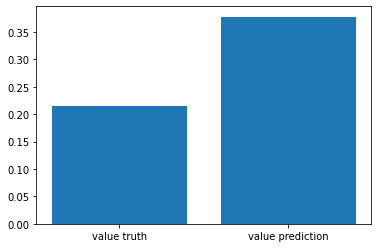

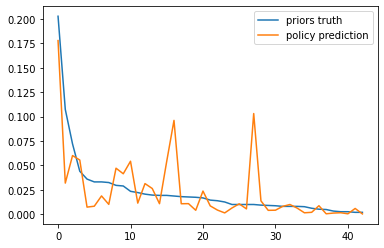

In [90]:
inspectRandomPrediction()

In [ ]:
# Create dataset and split into train & test data loaders

batchSize = 64
allDataset = DrillDataset(allSteps)

trainSize = int(len(allDataset) * 0.9)
testSize = len(allDataset) - trainSize

trainDataset, testDataset = random_split(allDataset, [trainSize, testSize])
trainDataLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)

print(len(trainDataset))
print(len(testDataset))

203202
22579


### Define loss function and optimizer

In [ ]:
# Define the loss function
# which will be the sum of these two
# (todo: think about weighting and alternatives)
policyCriterion = nn.CrossEntropyLoss()
valueCriterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=1e-4)

In [ ]:
# try the criterions
inputs, labels = next(iter(trainDataLoader))
# inputs = inputs.to(device)
# labels = labels.to(device)
values, policies = model(inputs)
# valueCriterion(values.squeeze(), labels[0])
# policyCriterion(policies.flatten(1), torch.argmax(labels[1].flatten(1), 1))
policyCriterion(policies.flatten(1), labels[1])
# labels[1].squeeze().shape
# policies.squeeze().squeeze().shape
# torch.argmax(labels[1].flatten(1), 1)
# labels[0], values


tensor(0.8413, device='cuda:0', grad_fn=<NllLossBackward>)

### Create/load epoch summaries

In [ ]:
def makeSummary(epoch, trainValueLoss, trainPolicyLoss, testValueLoss, testPolicyLoss) -> dict :
    return {
        "epoch": epoch,
        "trainValueLoss": trainValueLoss,
        "trainPolicyLoss": trainPolicyLoss,
        "testValueLoss": testValueLoss,
        "testPolicyLoss": testPolicyLoss
    }

In [ ]:
summaryFilePath = workingDirectory + "trainingSummaries.json"

summaries = []

# summaries.append(makeSummary(epoch=1, trainPolicyLoss=2.2, trainValueLoss=0.25, testPolicyLoss=3.2, testValueLoss=0.35))
# summaries.append(makeSummary(epoch=2, trainPolicyLoss=2.1, trainValueLoss=0.24, testPolicyLoss=3.1, testValueLoss=0.33))
# summaries.append(makeSummary(epoch=3, trainPolicyLoss=2.0, trainValueLoss=0.23, testPolicyLoss=3.0, testValueLoss=0.31))
# print(json.dumps(summaries, indent=4))

def loadSummaries():
    with open(summaryFilePath) as jsonFile:
        return json.load(jsonFile)

def saveSummaries(summaries):
    with open(summaryFilePath, 'w') as outfile:
        json.dump(summaries, outfile)


# summaries = loadSummaries()
# for item in summaries:
#     print(item)

# saveSummaries(summaries)



### Training/testing methods

In [ ]:
def performTraining(printStats=True) -> (float, float):
    """
    Do one epoch of training.  Returns the two training losses,
    i.e. value loss & policy loss.
    """
    model.train()

    totalCount = len(trainDataLoader)
    epochValueLoss = 0.0
    epochPolicyLoss = 0.0

    printFrequency = (totalCount // 1000) * 100
    runningValueLoss = 0.0
    runningPolicyLoss = 0.0

    for i, data in enumerate(trainDataLoader):
        inputs, labels = data
        optimizer.zero_grad()

        values, policies = model(inputs)
        valueLoss = valueCriterion(values.squeeze(), labels[0].to(device))
        policyLoss = policyCriterion(policies.flatten(1), labels[1])
        loss = 50 * valueLoss + policyLoss
        loss.backward()
        optimizer.step()

        epochValueLoss += valueLoss.item()
        epochPolicyLoss += policyLoss.item()

        # print statistics
        if printStats:
            runningValueLoss += valueLoss.item()
            runningPolicyLoss += policyLoss.item()
            if i % printFrequency == printFrequency - 1:    # print every _ mini-batches
                print('[%4d] loss: %.5f, %.3f' %
                    (i + 1, runningValueLoss / printFrequency,
                    runningPolicyLoss / printFrequency))
                runningValueLoss = 0.0
                runningPolicyLoss = 0.0

    return epochValueLoss / totalCount, epochPolicyLoss / totalCount

In [ ]:
def performTesting() -> (float, float):
    with torch.no_grad():
        model.eval()

        testingPolicyLoss = 0.0
        testingValueLoss = 0.0
        totalCount = len(testDataLoader)

        for data in testDataLoader:
            inputs, labels = data
            values, policies = model(inputs)
            valueLoss = valueCriterion(values.squeeze(), labels[0].to(device))
            policyLoss = policyCriterion(policies.flatten(1), labels[1])
            testingValueLoss += valueLoss.item()
            testingPolicyLoss += policyLoss.item()

    return testingValueLoss / totalCount, testingPolicyLoss / totalCount 

### Run

In [ ]:
iterations = 1
lastEpoch = summaries[-1]["epoch"] if summaries else 0
for epoch in range(lastEpoch + 1, lastEpoch + 1 + iterations):

    print(f"*** Epoch {epoch} ***")

    # trainValueLoss, trainPolicyLoss = performTraining(printStats=True)

    # print(f"Epoch {epoch} in {len(trainDataLoader)} minibatches:")
    # print(f"Average train value loss: {trainValueLoss:.5f}")
    # print(f"Average train policy loss: {trainPolicyLoss:.3f}")
    # print()

    testValueLoss, testPolicyLoss = performTesting()

    print(f"Testing in {len(testDataLoader)} minibatches:")
    print(f"Average test value loss: {testValueLoss:.5f}")
    print(f"Average test policy loss: {testPolicyLoss:.3f}")
    print("\n\n")

    # summaries.append(makeSummary(epoch=epoch,
    #                              trainValueLoss=trainValueLoss,
    #                              trainPolicyLoss=trainPolicyLoss,
    #                              testValueLoss=testValueLoss,
    #                              testPolicyLoss=testPolicyLoss))

    # saveSummaries(summaries)
    # saveTorchModel()

print('Finished Training')

*** Epoch 1 ***
Testing in 353 minibatches:
Average test value loss: 0.01530
Average test policy loss: 1.015



Finished Training


In [ ]:
print(len(summaries))
# summaries #[-1]

30


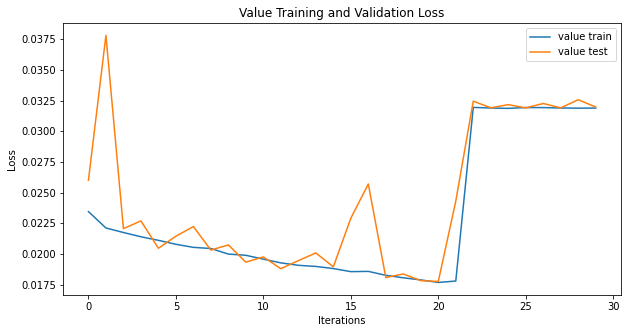

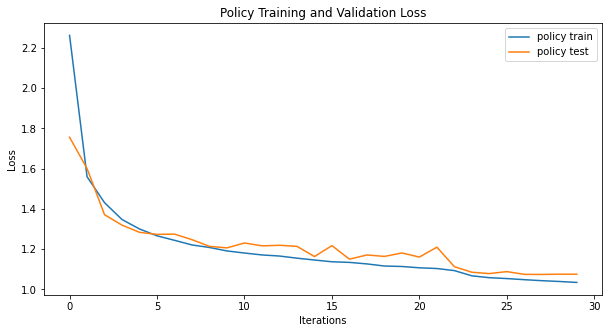

In [ ]:
trainValueLosses = [item["trainValueLoss"] for item in summaries]
trainPolicyLosses = [item["trainPolicyLoss"] for item in summaries]
testValueLosses = [item["testValueLoss"] for item in summaries]
testPolicyLosses = [item["testPolicyLoss"] for item in summaries]

plt.figure(figsize=(10,5))
plt.title("Value Training and Validation Loss")
plt.plot(trainValueLosses,label="value train")
plt.plot(testValueLosses,label="value test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Policy Training and Validation Loss")
plt.plot(trainPolicyLosses,label="policy train")
plt.plot(testPolicyLosses,label="policy test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### TODOs

- Loss visualization
    - https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
    - https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb
    - https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb
- See if we get to a point where training loss is decreasing but validation loss doesn't
    - Can I overfit?
- Showing some sample outputs
- Automatic saving for long training
    - model
        - https://stackoverflow.com/questions/10607688/how-to-create-a-file-name-with-the-current-date-time-in-python
    - training and testing accuracies

- In the future, might simplify the saved game records by tossing the full search result priors -- I didn't realize in training only the top result is considered.  This might make the record files drastically smaller.

## Save training progress

## Export to CoreML

- Need: metadata descriptions for the model (esp. want proper names for policy and value in the output names)


In [ ]:
# model = DrillModel(4)


inputs, labels = next(iter(trainDataLoader))
# inputs = inputs.to(device)
# labels = labels.to(device)
values, policies = model(inputs)

model.eval()
# sample = torch.from_numpy(sampleFromStep(allSteps[0])).unsqueeze(0)
sample = next(iter(trainDataLoader))[0][0:1]

tracedModel = torch.jit.trace(model, sample)
mlmodel = ct.convert(
    tracedModel,
    inputs=[ct.TensorType(name="input", shape=sample.shape)]
    # convert_to="mlprogram"
)
mlmodel

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 104/104 [00:00<00:00, 4033.10 ops/s]


input {
  name: "input"
  type {
    multiArrayType {
      shape: 1
      shape: 43
      shape: 20
      shape: 10
      dataType: FLOAT32
    }
  }
}
output {
  name: "205"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "186"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.9.0+cu102"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.0b4"
  }
}

In [ ]:
mlmodelFileName = "DrillModelCoreML.mlmodel"
mlmodel.save(mlmodelFileName)

In [ ]:
# !zip -r DrillModel {mlmodelFileName}/

  adding: DrillModelCoreML.mlpackage/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Manifest.json (deflated 60%)
  adding: DrillModelCoreML.mlpackage/Data/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/weights/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/weights/weight.bin (deflated 7%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 84%)


In [ ]:

## Debugging


# model = TestModel(5, 3, 3, 1)
# model = ResidualBlock(5, 3)
# model = ConvBN(5, 5, 3, 1)
# model = DrillModel(4)
exampleInput = torch.rand(1, 5, 20, 10)
tracedModel = torch.jit.trace(model, exampleInput)
mlmodel = ct.convert(
    tracedModel,
    inputs=[ct.TensorType(shape=exampleInput.shape)]
)
mlmodel
# model(exampleInput).shape



In [ ]:
mlmodel = ct.convert(
    tracedModel,
    inputs=[ct.TensorType(shape=sample.shape)])

Converting Frontend ==> MIL Ops:  40%|████      | 4/10 [00:00<00:00, 3056.52 ops/s]


RuntimeError: ignored

In [ ]:
import torch
import torchvision

# Load a pre-trained version of MobileNetV2
torch_model = torchvision.models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
torch_model.eval()

In [ ]:
# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)

In [ ]:
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input_1", shape=example_input.shape)] #name "input_1" is used in 'quickstart'
)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 495/495 [00:00<00:00, 822.70 ops/s] 
